Example from scikit downscale

In [1]:
# modules
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt

time_slice = slice('1990-01-01', '1990-12-31')

from sklearn.model_selection import train_test_split
from utils import get_sample_data

In [2]:
# function to plot

In [3]:
# utilities for plotting cdfs
def plot_cdf(ax=None, **kwargs):
    if ax:
        plt.sca(ax)
    else:
        ax = plt.gca()

    for label, X in kwargs.items():
        vals = np.sort(X, axis=0)
        pp = scipy.stats.mstats.plotting_positions(vals)
        ax.plot(pp, vals, label=label)
    ax.legend()
    return ax


def plot_cdf_by_month(ax=None, **kwargs):
    fig, axes = plt.subplots(4, 3, sharex=True, sharey=False, figsize=(12, 8))

    for label, X in kwargs.items():
        for month, ax in zip(range(1, 13), axes.flat):

            vals = np.sort(X[X.index.month == month], axis=0)
            pp = scipy.stats.mstats.plotting_positions(vals)
            ax.plot(pp, vals, label=label)
            ax.set_title(month)
    ax.legend()
    return ax

https://github.com/pangeo-data/scikit-downscale/blob/main/examples/2020ECAHM-scikit-downscale.ipynb

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import numpy as np
import pandas as pd
import scipy
import xarray as xr
import os
import os.path

import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
# load sample data

In [6]:
from Functions_ImportData import import_treat_modeled_NEX_GDDP_CMIP6
from Functions_ImportData import import_treat_obs_NOAA
from Functions_ImportData import import_treat_modeled_NEX_GDDP_CMIP6_close_to_stationNOAA
from Bias_correction_function import BC
from Bias_correction_function import treat_data_for_test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
data_obs_NOAA=import_treat_obs_NOAA()
climate_var_NEX_GDDP_CMIP6_EmplacementStation=import_treat_modeled_NEX_GDDP_CMIP6_close_to_stationNOAA('pr', 'mm_per_day')
df_pr = treat_data_for_test(data_obs_NOAA,'PRCP',climate_var_NEX_GDDP_CMIP6_EmplacementStation,'Mean of the daily precipitation rate mm/day','BEIRA, MZ','ACCESS-CM2')

In [8]:
df_pr['training']

,pcp
time,
1970-01-01,15.221261
1970-01-02,15.258603
1970-01-03,3.232764
1970-01-04,0.340715
1970-01-05,2.544045
...,...
2014-12-16,0.000000
2014-12-17,0.095924
2014-12-18,0.272668


"\ntraining[time_slice]['pcp'].plot(ax=axes[1])\ntargets[time_slice]['pcp'].plot(ax=axes[1])\n_ = axes[1].set_ylabel('Precipitation [mm/day]')"

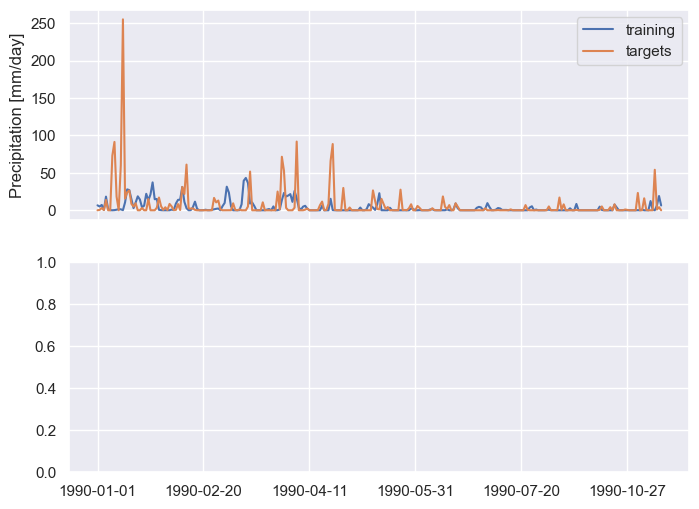

In [9]:
# load sample data
r'''
data = xr.open_zarr('../data/downscale_test_data.zarr.zip', group='training')
# extract 1 point of training data for precipitation and temperature
df = (
    data.isel(point=0)
    .to_dataframe()[['T2max', 'PREC_TOT']]
    .rename(columns={'T2max': 'tmax', 'PREC_TOT': 'pcp'})
)
df['tmax'] -= 273.13
df['pcp'] *= 24
training= df.resample('1d').first()
data = xr.open_zarr('../data/downscale_test_data.zarr.zip', group='targets')
        # extract 1 point of training data for precipitation and temperature
targets =data.isel(point=0).to_dataframe()[['Tmax', 'Prec']].rename(columns={'Tmax': 'tmax', 'Prec': 'pcp'})


# print a table of the training/targets data
display(pd.concat({'training': training, 'targets': targets}, axis=1))
'''
training=df_pr['training']
targets=df_pr['targets']
# make a plot of the temperature and precipitation data
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(8, 6), sharex=True)
time_slice = slice('1990-01-01', '1990-12-31')

# plot-temperature
training[time_slice]['pcp'].plot(ax=axes[0], label='training')
targets[time_slice]['pcp'].plot(ax=axes[0], label='targets')
axes[0].legend()
axes[0].set_ylabel('Precipitation [mm/day]')

# plot-precipitation
r'''
training[time_slice]['pcp'].plot(ax=axes[1])
targets[time_slice]['pcp'].plot(ax=axes[1])
_ = axes[1].set_ylabel('Precipitation [mm/day]')'''

In [10]:
# exploratory data analysis for arrm model

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import KBinsDiscretizer
from mlinsights.mlmodel import PiecewiseRegressor

def ARRM(n_bins=7):
    return Pipeline([
        ('')
    ])


sns.set(style='whitegrid')
c = {'train': 'black', 'predict': 'blue', 'test': 'grey'}

qqwargs = {'n_quantiles': 1e6, 'copy': True, 'subsample': 1e6}
n_bins = 7

X = training[['pcp']]['1980': '2000'].values
y = targets[['pcp']]['1980': '2000'].values

X_train, X_test, y_train, y_test = train_test_split(X, y)

kmeans 0.011884857155657347
uniform 0.019388636215139532
quantile 0.016239880005076812


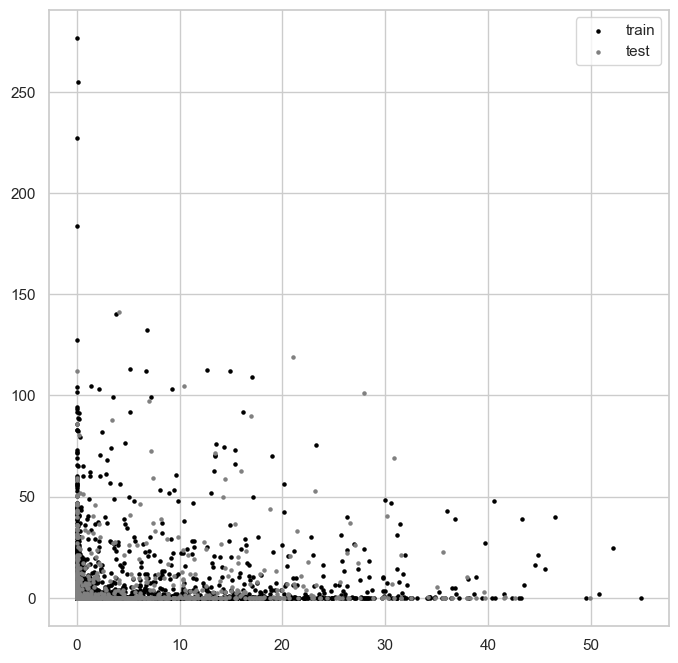

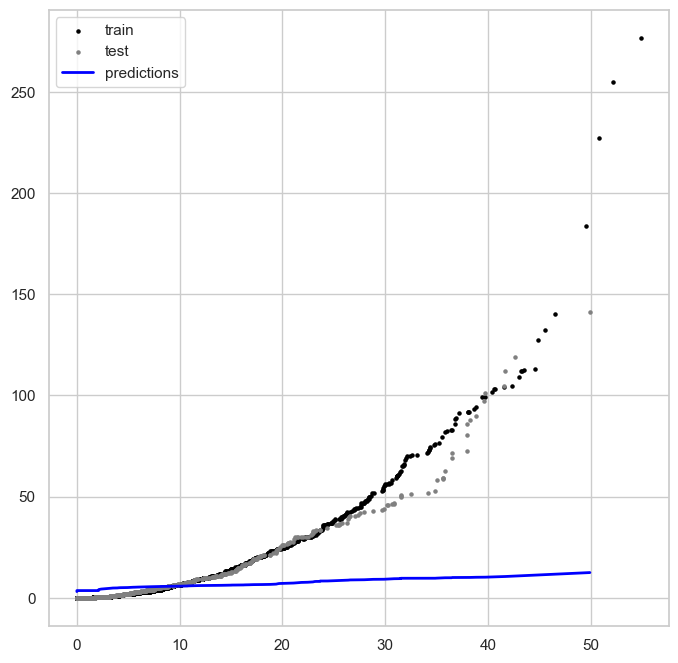

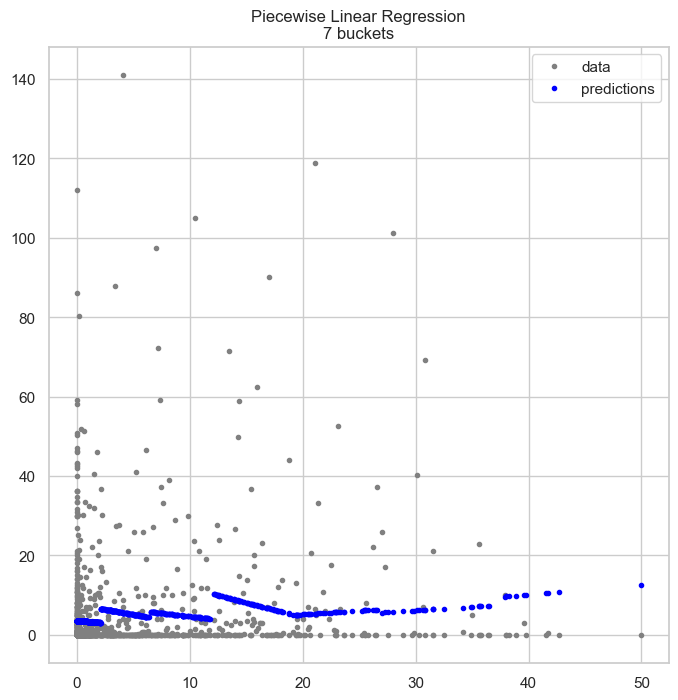

In [11]:
y_train = y_train[:, 0]
for strat in ['kmeans', 'uniform', 'quantile']:
    model = PiecewiseRegressor(binner=KBinsDiscretizer(n_bins=n_bins, strategy=strat))

    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(strat, model.score(X_test, y_test))
    
model = PiecewiseRegressor(binner=KBinsDiscretizer(n_bins=n_bins, strategy='kmeans'))
model.fit(X_train, y_train)
pred = model.predict(X_test)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.scatter(X_train, y_train, c=c['train'], s=5, label='train')
plt.scatter(X_test, y_test, c=c['test'], s=5, label='test')
ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.scatter(np.sort(X_train, axis=0), np.sort(y_train, axis=0), c=c['train'], s=5, label='train')
plt.scatter(np.sort(X_test, axis=0), np.sort(y_test, axis=0), c=c['test'], s=5, label='test')
plt.plot(np.sort(X_test, axis=0), np.sort(pred, axis=0), c=c['predict'], lw=2, label='predictions')
ax.legend()

# fig, ax = plt.subplots(1, 1)
# ax.plot(Xq_test[:, 0], yq_test, ".", label='data', c=c['test'])
# ax.plot(Xq_test[:, 0], predq, ".", label="predictions", c=c['predict'])
# ax.set_title(f"Piecewise Linear Regression\n{n_bins} buckets")
# ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(X_test[:, 0], y_test, ".", label='data', c=c['test'])
ax.plot(X_test[:, 0], pred, ".", label="predictions", c=c['predict'])
ax.set_title(f"Piecewise Linear Regression\n{n_bins} buckets")
ax.legend()

https://github.com/pangeo-data/scikit-downscale/blob/main/examples/bcsd_example.ipynb

In [12]:
# open a small dataset for training
training = xr.open_zarr("../data/downscale_test_data.zarr.zip", group="training")
training

<xarray.Dataset>
Dimensions:      (point: 5, time: 13483)
Coordinates:
    lat          (point) float32 ...
    lon          (point) float32 ...
  * time         (time) datetime64[ns] 1979-01-01T11:30:00 ... 2015-11-30T11:...
Dimensions without coordinates: point
Data variables: (12/15)
    DIV          (point, time) float32 ...
    PREC_ACC_C   (point, time) float32 ...
    PREC_ACC_NC  (point, time) float32 ...
    PREC_TOT     (point, time) float32 ...
    PSFC         (point, time) float32 ...
    QVAPOR       (point, time) float32 ...
    ...           ...
    T2min        (point, time) float32 ...
    T_MEAN       (point, time) float32 ...
    T_RANGE      (point, time) float32 ...
    U            (point, time) float32 ...
    V            (point, time) float32 ...
    W            (point, time) float32 ...
Attributes:
    NCO:                        "4.5.5"
    history:                    Wed Mar  1 13:48:35 2017: ncatted -a calendar...
    history_of_appended_files:  Wed Feb  8 14:15:52 2017: Appended file wrf_d...
    nco_openmp_thread_number:   1

In [13]:
# open a small dataset of observations (targets)
targets = xr.open_zarr("../data/downscale_test_data.zarr.zip", group="targets")
targets

<xarray.Dataset>
Dimensions:  (time: 23376, point: 5)
Coordinates:
    lat      (point) float64 ...
    lon      (point) float64 ...
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2013-12-31
Dimensions without coordinates: point
Data variables:
    Prec     (time, point) float32 ...
    Tmax     (time, point) float32 ...
    Tmin     (time, point) float32 ...
    wind     (time, point) float32 ...
Attributes:
    CDI:                       Climate Data Interface version 1.6.4 (http://c...
    CDO:                       Climate Data Operators version 1.6.4 (http://c...
    Conventions:               CF-1.4
    NCO:                       4.4.5
    history:                   Fri Oct 10 17:54:37 2014: cdo ifthenelse /Volu...
    nco_openmp_thread_number:  1

In [14]:
# extract 1 point of training data for precipitation and temperature
X_temp = training.isel(point=0).to_dataframe()[["T2max"]].resample("MS").mean() - 273.13
X_pcp = training.isel(point=0).to_dataframe()[["PREC_TOT"]].resample("MS").sum() * 24
display(X_temp.head(), X_pcp.head())

,T2max
time,
1979-01-01,3.174103
1979-02-01,5.273163
1979-03-01,13.126099
1979-04-01,13.500275
1979-05-01,20.057251


,PREC_TOT
time,
1979-01-01,102.553276
1979-02-01,216.159973
1979-03-01,98.423416
1979-04-01,129.309418
1979-05-01,41.323780


In [15]:
# extract 1 point of target data for precipitation and temperature
y_temp = targets.isel(point=0).to_dataframe()[["Tmax"]].resample("MS").mean()
y_pcp = targets.isel(point=0).to_dataframe()[["Prec"]].resample("MS").sum()
display(y_temp.head(), y_pcp.head())

,Tmax
time,
1950-01-01,-2.065484
1950-02-01,6.638215
1950-03-01,8.544193
1950-04-01,13.238667
1950-05-01,16.199354


,Prec
time,
1950-01-01,214.043198
1950-02-01,237.654190
1950-03-01,269.569855
1950-04-01,149.984604
1950-05-01,65.975349


<Axes: title={'center': '12'}>

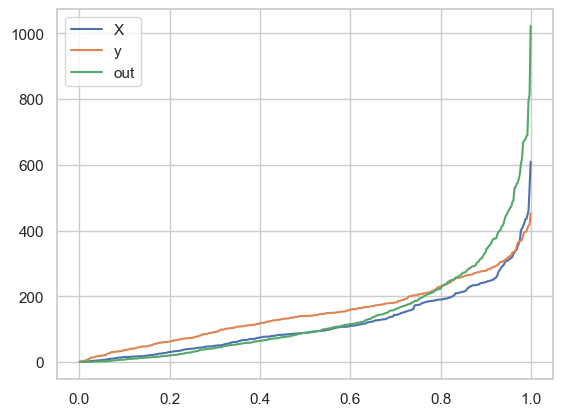

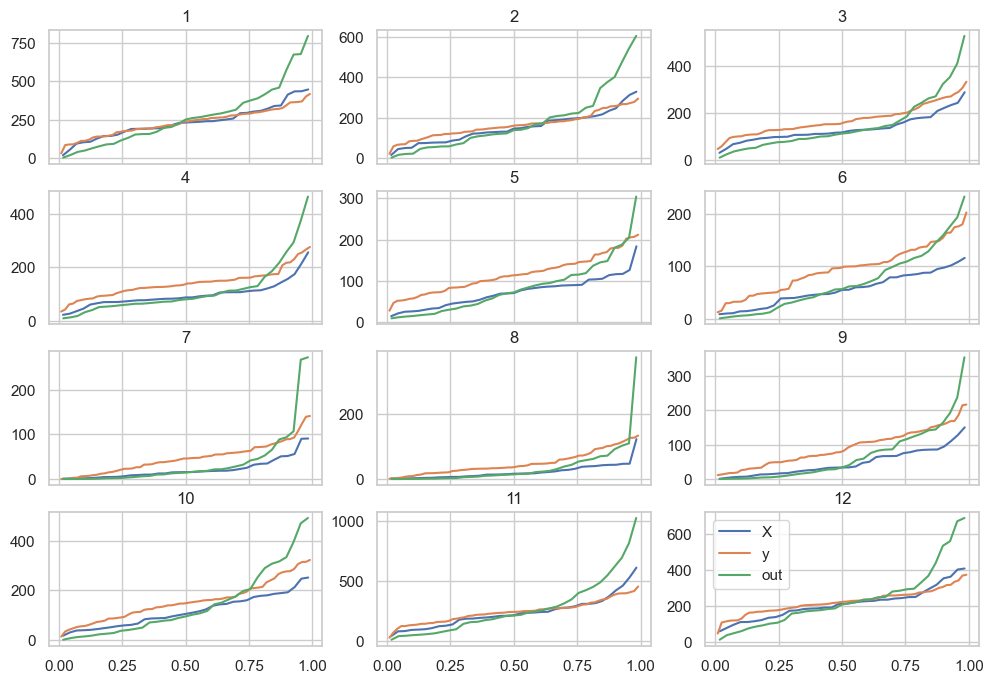

In [16]:
# Fit/predict the BCSD Precipitation model
from skdownscale.pointwise_models import BcsdPrecipitation
bcsd_pcp = BcsdPrecipitation()
bcsd_pcp.fit(X_pcp.loc['1979':'2013'], y_pcp.loc['1979':'2013'])
out = bcsd_pcp.predict(X_pcp.loc['1979':'2013']) * X_pcp.loc['1979':'2013']
plot_cdf(X=X_pcp.loc['1979':'2013'], y=y_pcp.loc['1979':'2013'], out=out)
plot_cdf_by_month(X=X_pcp, y=y_pcp, out=out)

## 2.2 Models as cattle, not pets

https://github.com/earthcube2020/ec20_hamman_etal/blob/master/2020ECAHM-scikit-downscale.ipynb

In [17]:
from mlinsights.mlmodel import PiecewiseRegressor
from sklearn.preprocessing import KBinsDiscretizer

In [18]:
# load sample data
data = xr.open_zarr('../data/downscale_test_data.zarr.zip', group='training')
# extract 1 point of training data for precipitation and temperature
df = (
    data.isel(point=0)
    .to_dataframe()[['T2max', 'PREC_TOT']]
    .rename(columns={'T2max': 'tmax', 'PREC_TOT': 'pcp'})
)
df['tmax'] -= 273.13
df['pcp'] *= 24
training= df.resample('1d').first()
data = xr.open_zarr('../data/downscale_test_data.zarr.zip', group='targets')
        # extract 1 point of training data for precipitation and temperature
targets =data.isel(point=0).to_dataframe()[['Tmax', 'Prec']].rename(columns={'Tmax': 'tmax', 'Prec': 'pcp'})


In [19]:
def ARRM(n_bins=7):
    return Pipeline([
        ('')
    ])


sns.set(style='whitegrid')
c = {'train': 'black', 'predict': 'blue', 'test': 'grey'}

qqwargs = {'n_quantiles': 1e6, 'copy': True, 'subsample': 1e6}
n_bins = 7

In [20]:
X = training[['pcp']]['1980': '2000'].values
y = targets[['pcp']]['1980': '2000'].values

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [21]:
y_train = y_train[:, 0]
    
model = PiecewiseRegressor(binner=KBinsDiscretizer(n_bins=n_bins, strategy='kmeans'))
#print(strat, model.score(X_test, y_test))
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from skdownscale.pointwise_models import PureAnalog, AnalogRegression
from skdownscale.pointwise_models import BcsdTemperature, BcsdPrecipitation


models = {
    'GARD: PureAnalog-best-1': PureAnalog(kind='best_analog', n_analogs=1),
    'GARD: PureAnalog-sample-10': PureAnalog(kind='sample_analogs', n_analogs=10),
    'GARD: PureAnalog-weight-10': PureAnalog(kind='weight_analogs', n_analogs=10),
    'GARD: PureAnalog-weight-100': PureAnalog(kind='weight_analogs', n_analogs=100),
    'GARD: PureAnalog-mean-10': PureAnalog(kind='mean_analogs', n_analogs=10),
    'GARD: AnalogRegression-100': AnalogRegression(n_analogs=100),
    'GARD: LinearRegression': LinearRegression(),
    'BCSD: BcsdTemperature': BcsdTemperature(return_anoms=False),
    'Sklearn: RandomForestRegressor': RandomForestRegressor(random_state=0)
}

train_slice = slice('1980-01-01', '1989-12-31')
predict_slice = slice('1990-01-01', '1999-12-31')

In [23]:
# extract training / prediction data
X_train = training[['pcp']][train_slice]
y_train = targets[['pcp']][train_slice]
X_predict = training[['pcp']][predict_slice]

# Fit all models
for key, model in models.items():
    model.fit(X_train, y_train)

In [24]:
# store predicted results in this dataframe
predict_df = pd.DataFrame(index = X_predict.index)

for key, model in models.items():
    print('key')
    print(key)
    print('model')
    print(model)
    print(model.predict(X_predict))
    if type(model.predict(X_predict))==pd.core.frame.DataFrame:
        if len(list(model.predict(X_predict).columns))>1:
            predict_df[key] = model.predict(X_predict)[['pred']].values # [['pred']] added to deal with piecewise regressor
        else:
            predict_df[key] = model.predict(X_predict)
    else:
        predict_df[key] = model.predict(X_predict) # [['pred']] added to deal with piecewise regressor

# show a table of the predicted data
display(predict_df.head())

key
GARD: PureAnalog-best-1
model
PureAnalog(n_analogs=1)
           pred  exceedance_prob  prediction_error
0      2.337239              1.0               0.0
1     14.853088              1.0               0.0
2     18.088530              1.0               0.0
3     14.195801              1.0               0.0
4      7.896709              1.0               0.0
...         ...              ...               ...
3647   0.000000              1.0               0.0
3648   0.000000              1.0               0.0
3649   1.139888              1.0               0.0
3650   0.765105              1.0               0.0
3651  12.132585              1.0               0.0

[3652 rows x 3 columns]
key
GARD: PureAnalog-sample-10
model
PureAnalog(kind='sample_analogs', n_analogs=10)
           pred  exceedance_prob  prediction_error
0     11.465477              1.0          5.292640
1     10.670458              1.0          4.974919
2      9.197550              1.0          4.364806
3      9.197550 

,GARD: PureAnalog-best-1,GARD: PureAnalog-sample-10,GARD: PureAnalog-weight-10,GARD: PureAnalog-weight-100,GARD: PureAnalog-mean-10,GARD: AnalogRegression-100,GARD: LinearRegression,BCSD: BcsdTemperature,Sklearn: RandomForestRegressor
time,,,,,,,,,
1990-01-01,2.337239,6.021834,7.879466,8.375086,9.401106,9.644264,6.780540,5.012530,5.525192
1990-01-02,14.853088,2.455552,10.756211,10.369333,9.023921,9.935296,6.956942,5.459010,11.760718
1990-01-03,18.088530,10.597134,12.232565,13.146371,11.674385,13.505336,10.639250,16.253233,15.986740
1990-01-04,14.195801,14.195801,11.228598,12.724728,11.344765,13.590366,10.665932,16.070140,11.880678
1990-01-05,7.896709,10.670458,10.837737,10.160286,10.623667,9.930517,6.986295,13.776080,10.195431


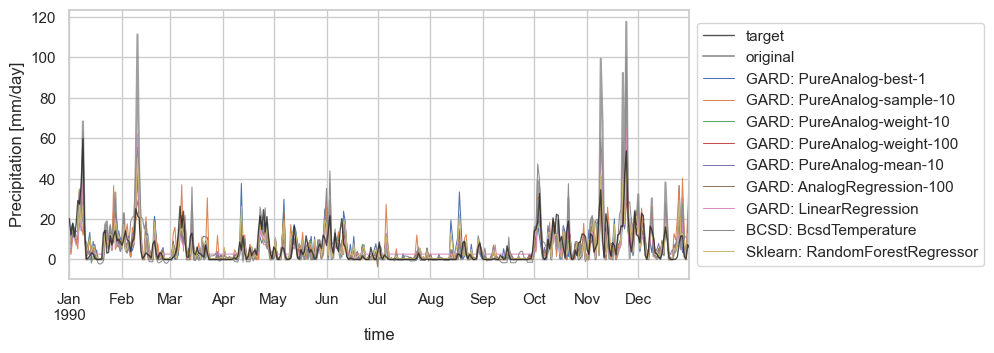

In [25]:
fig, ax = plt.subplots(figsize=(8, 3.5))
targets['pcp'][time_slice].plot(ax=ax, label='target', c='k', lw=1, alpha=0.75, legend=True, zorder=10)
X_predict['pcp'][time_slice].plot(label='original', c='grey', ax=ax, alpha=0.75, legend=True)
predict_df[time_slice].plot(ax=ax, lw=0.75)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax.set_ylabel('Precipitation [mm/day]')

In [26]:
# calculate r2
score = (predict_df.corrwith(targets.pcp[predict_slice]) **2).sort_values().to_frame('r2_score')
display(score)

,r2_score
GARD: PureAnalog-best-1,0.305629
GARD: PureAnalog-sample-10,0.313206
Sklearn: RandomForestRegressor,0.404786
GARD: LinearRegression,0.446720
GARD: PureAnalog-weight-10,0.451827
BCSD: BcsdTemperature,0.482129
GARD: PureAnalog-weight-100,0.490189
GARD: PureAnalog-mean-10,0.516816
GARD: AnalogRegression-100,0.550006


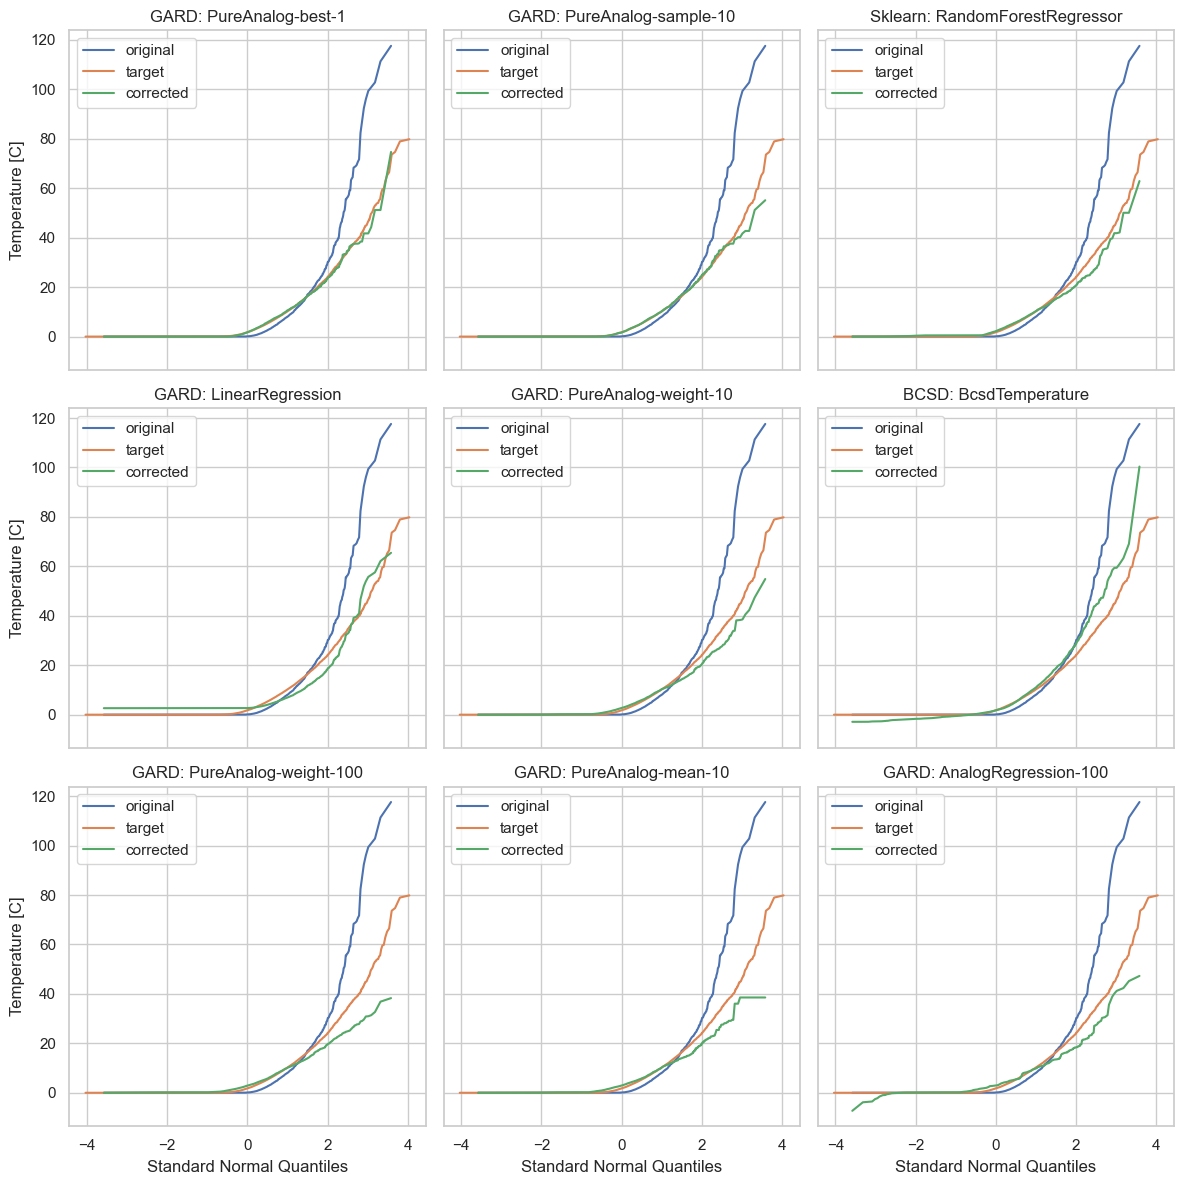

In [27]:
from utils import prob_plots

fig = prob_plots(X_predict, targets['pcp'], predict_df[score.index.values], shape=(3, 3), figsize=(12, 12))


## Zscore

Z-Score bias correction is a good technique for target variables with Gaussian probability distributions, such as zonal wind speed.

In [28]:
from skdownscale.pointwise_models import ZScoreRegressor

In [29]:
# load sample data
data = xr.open_zarr('../data/downscale_test_data.zarr.zip', group='training')
# extract 1 point of training data for precipitation and temperature
df = (
    data.isel(point=0)
    .to_dataframe()[['T2max', 'PREC_TOT']]
    .rename(columns={'T2max': 'tmax', 'PREC_TOT': 'pcp'})
)
df['tmax'] -= 273.13
df['pcp'] *= 24
training= df.resample('1d').first()
data = xr.open_zarr('../data/downscale_test_data.zarr.zip', group='targets')
        # extract 1 point of training data for precipitation and temperature
targets =data.isel(point=0).to_dataframe()[['Tmax', 'Prec']].rename(columns={'Tmax': 'tmax', 'Prec': 'pcp'})


In [30]:
Trainings = training[['tmax']][train_slice]
target = targets[['tmax']][train_slice]
future = training[['tmax']][predict_slice]

In [31]:

# open a small dataset
training = get_sample_data('wind-hist')
target = get_sample_data('wind-obs')
future = get_sample_data('wind-rcp')

FileNotFoundError: [Errno 2] No such file or directory: b'C:\\Users\\CLMRX\\OneDrive - COWI\\Documents\\GitHub\\data\\uas\\uas.hist.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.Colorado.19801990.nc'

In [ ]:
# bias correction using ZScoreRegresssor
zscore = ZScoreRegressor()
zscore.fit(Trainings, target)
fit_stats = zscore.fit_stats_dict_
out = zscore.predict(future)
predict_stats = zscore.predict_stats_dict_

In [ ]:
# visualize the datasets
from utils import zscore_ds_plot

zscore_ds_plot(training, target, future, out)

In [ ]:
from utils import zscore_correction_plot

zscore_correction_plot(zscore)

## Automatic parallelization

In [ ]:
# parameters
train_slice = slice('1980', '1982')  # train time range
holdout_slice = slice('1990', '1991')  # prediction time range

# bounding box of downscaling region
lon_slice = slice(-124.8, -120.0) 
lat_slice = slice(50, 45)

# chunk shape for dask execution (time must be contiguous, ie -1)
chunks = {'lat': 10, 'lon': 10, 'time': -1}

In [ ]:
from dask.distributed import Client

client = Client()
client

In [ ]:
import xarray as xr

fnames = [f'http://thredds.northwestknowledge.net:8080/thredds/dodsC/MET/tmmx/tmmx_{year}.nc'
          for year in range(int(train_slice.start), int(train_slice.stop) + 1)]
# open the data and cleanup a bit of metadata
obs = xr.open_mfdataset(fnames, engine='pydap',combine='nested', concat_dim='day').rename({'day': 'time'}).drop('crs')

obs_subset = obs['air_temperature'].sel(time=train_slice, lon=lon_slice, lat=lat_slice).resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

# display
display(obs_subset)
obs_subset.isel(time=0).plot()

# Add models to list

In [32]:
from mlinsights.mlmodel import QuantileLinearRegression
from mlinsights.mlmodel import PiecewiseRegressor
from mlinsights.mlmodel import QuantileMLPRegressor
from sklearn.preprocessing import KBinsDiscretizer

In [33]:
X = training[['pcp']]['1980': '2000'].values
y = targets[['pcp']]['1980': '2000'].values

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from skdownscale.pointwise_models import PureAnalog, AnalogRegression
from skdownscale.pointwise_models import BcsdTemperature, BcsdPrecipitation


models = {
    'GARD: PureAnalog-best-1': PureAnalog(kind='best_analog', n_analogs=1),
    'GARD: PureAnalog-sample-10': PureAnalog(kind='sample_analogs', n_analogs=10),
    'GARD: PureAnalog-weight-10': PureAnalog(kind='weight_analogs', n_analogs=10),
    'GARD: PureAnalog-weight-100': PureAnalog(kind='weight_analogs', n_analogs=100),
    'GARD: PureAnalog-mean-10': PureAnalog(kind='mean_analogs', n_analogs=10),
    'GARD: AnalogRegression-100': AnalogRegression(n_analogs=100),
    'GARD: LinearRegression': LinearRegression(),
    'BCSD: BcsdTemperature': BcsdTemperature(return_anoms=False),
    'Sklearn: RandomForestRegressor': RandomForestRegressor(random_state=0),
    'Sklearn: QuantileMLPRegressor': QuantileMLPRegressor(),
    'Sklearn: QuantileLinearRegression': QuantileLinearRegression(),
    #'Sklearn: PiecewiseRegressor': PiecewiseRegressor(binner=KBinsDiscretizer(n_bins=n_bins, strategy='kmeans'))
    
}

train_slice = slice('1980-01-01', '1989-12-31')
predict_slice = slice('1990-01-01', '1999-12-31')

In [35]:
# extract training / prediction data
X_train = training[['pcp']][train_slice]
y_train = targets[['pcp']][train_slice]
X_predict = training[['pcp']][predict_slice]

# Fit all models
for key, model in models.items():
    print(model)
    if 'PiecewiseRegressor' in key: # does't work
        model.fit(X_train.values.reshape((len(X_train),1)), y_train.values.reshape((len(y_train),)))
    if 'QuantileLinearRegression' in key:
        model.fit(X_train.values.reshape((len(X_train.values),1)), y_train.values.reshape((len(y_train.values),)))
    else:
        model.fit(X_train, y_train)

PureAnalog(n_analogs=1)
PureAnalog(kind='sample_analogs', n_analogs=10)
PureAnalog(kind='weight_analogs', n_analogs=10)
PureAnalog(kind='weight_analogs', n_analogs=100)
PureAnalog(kind='mean_analogs', n_analogs=10)
AnalogRegression(n_analogs=100)
LinearRegression()
BcsdTemperature(return_anoms=False)
RandomForestRegressor(random_state=0)
QuantileMLPRegressor()
QuantileLinearRegression()


In [36]:
# store predicted results in this dataframe
predict_df = pd.DataFrame(index = X_predict.index)

for key, model in models.items():
    print('key')
    print(key)
    print('model')
    print(model)
    if 'PiecewiseRegressor' in key: # does't work
        predict_df[key] = model.predict(X_predict)
    if type(model.predict(X_predict))==pd.core.frame.DataFrame:
        if len(list(model.predict(X_predict).columns))>1:
            predict_df[key] = model.predict(X_predict)[['pred']].values # [['pred']] added to deal with piecewise regressor
        else:
            predict_df[key] = model.predict(X_predict)
    else:
        predict_df[key] = model.predict(X_predict) # [['pred']] added to deal with piecewise regressor

# show a table of the predicted data
display(predict_df.head())

key
GARD: PureAnalog-best-1
model
PureAnalog(n_analogs=1)
key
GARD: PureAnalog-sample-10
model
PureAnalog(kind='sample_analogs', n_analogs=10)
key
GARD: PureAnalog-weight-10
model
PureAnalog(kind='weight_analogs', n_analogs=10)
key
GARD: PureAnalog-weight-100
model
PureAnalog(kind='weight_analogs', n_analogs=100)
key
GARD: PureAnalog-mean-10
model
PureAnalog(kind='mean_analogs', n_analogs=10)
key
GARD: AnalogRegression-100
model
AnalogRegression(n_analogs=100)
key
GARD: LinearRegression
model
LinearRegression()
key
BCSD: BcsdTemperature
model
BcsdTemperature(return_anoms=False)
key
Sklearn: RandomForestRegressor
model
RandomForestRegressor(random_state=0)
key
Sklearn: QuantileMLPRegressor
model
QuantileMLPRegressor()
key
Sklearn: QuantileLinearRegression
model
QuantileLinearRegression()


,GARD: PureAnalog-best-1,GARD: PureAnalog-sample-10,GARD: PureAnalog-weight-10,GARD: PureAnalog-weight-100,GARD: PureAnalog-mean-10,GARD: AnalogRegression-100,GARD: LinearRegression,BCSD: BcsdTemperature,Sklearn: RandomForestRegressor,Sklearn: QuantileMLPRegressor,Sklearn: QuantileLinearRegression
time,,,,,,,,,,,
1990-01-01,2.337239,14.096723,7.879466,8.375086,9.401106,9.644264,6.780540,5.012530,5.525192,8.451376,6.083645
1990-01-02,14.853088,5.690137,10.756211,10.369333,9.023921,9.935296,6.956942,5.459010,11.760718,8.638807,6.299173
1990-01-03,18.088530,10.597134,12.232565,13.146371,11.674385,13.505336,10.639250,16.253233,15.986740,11.294140,10.798232
1990-01-04,14.195801,8.641136,11.228598,12.724728,11.344765,13.590366,10.665932,16.070140,11.880678,11.313308,10.830831
1990-01-05,7.896709,11.080254,10.837737,10.160286,10.623667,9.930517,6.986295,13.776080,10.195431,8.664604,6.335037


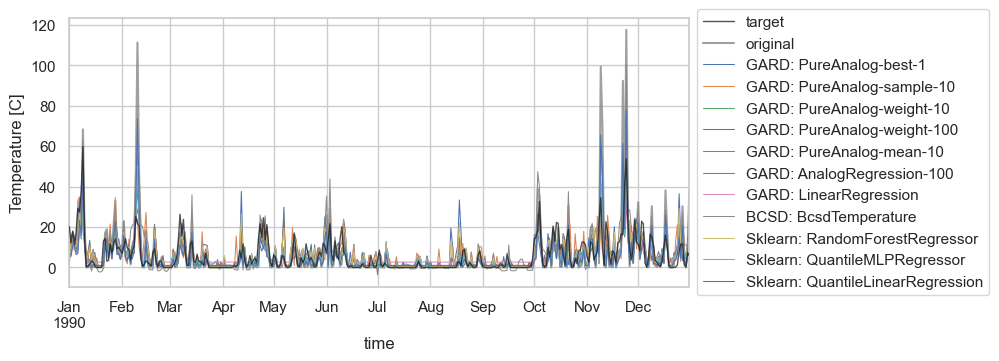

In [37]:
fig, ax = plt.subplots(figsize=(8, 3.5))
targets['pcp'][time_slice].plot(ax=ax, label='target', c='k', lw=1, alpha=0.75, legend=True, zorder=10)
X_predict['pcp'][time_slice].plot(label='original', c='grey', ax=ax, alpha=0.75, legend=True)
predict_df[time_slice].plot(ax=ax, lw=0.75)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax.set_ylabel('Temperature [C]')

In [38]:
# calculate r2
score = (predict_df.corrwith(targets.tmax[predict_slice]) **2).sort_values().to_frame('r2_score')
display(score)

,r2_score
Sklearn: QuantileLinearRegression,0.069787
GARD: LinearRegression,0.069787
GARD: PureAnalog-sample-10,0.091951
BCSD: BcsdTemperature,0.093013
GARD: PureAnalog-best-1,0.100578
Sklearn: RandomForestRegressor,0.125082
Sklearn: QuantileMLPRegressor,0.137771
GARD: PureAnalog-weight-10,0.141696
GARD: PureAnalog-mean-10,0.158284
GARD: PureAnalog-weight-100,0.159159


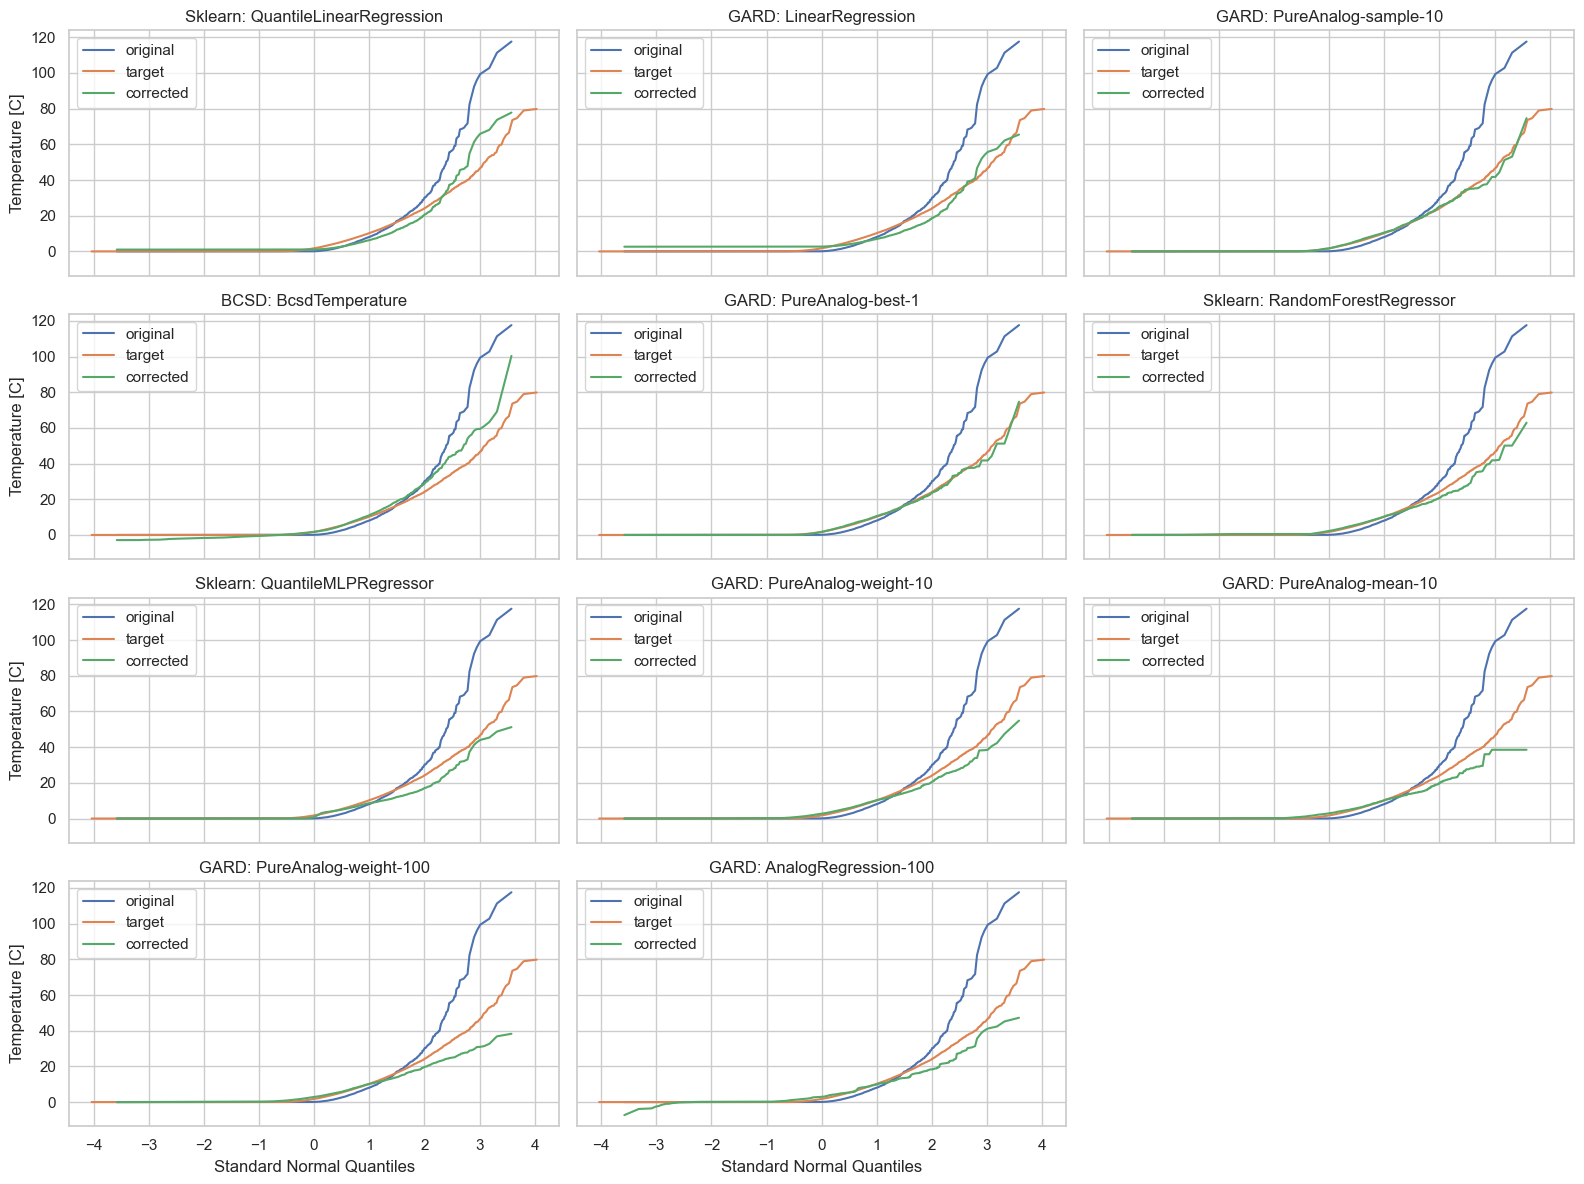

In [39]:
from utils import prob_plots

fig = prob_plots(X_predict, targets['pcp'], predict_df[score.index.values], shape=(4, 3), figsize=(16, 12))